In [1]:
import polars as pl 
import sys
from pathlib import Path
import importlib
import matplotlib.pyplot as plt
import numpy as np 
import polars as pl 
import bioframe as bf # https://bioframe.readthedocs.io/en/latest/index.html
from collections import Counter
from matplotlib_venn import venn2

# Set the font family to Arial
# https://g.co/gemini/share/3898a74b2d77
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = ['Arial'] # Add Arial to the sans-serif list

plt.rcParams.update({
    'font.size': 20,
})

REFERENCE_GENOME = "hg38"
TILE_SIZE = 1000
METH_READ_PHASED_DIR = Path('/scratch/ucgd/lustre-labs/quinlan/data-shared/dna-methylation/CEPH1463.GRCh38.hifi.founder-phased.all-cpgs')
SAMPLE = '200081' 
BED_METH = f"{METH_READ_PHASED_DIR}/{SAMPLE}.dna-methylation.founder-phased.all_cpgs.bed"

REPO_DIR = Path("/scratch/ucgd/lustre-labs/quinlan/u6018199/tapestry")
sys.path.append(str(REPO_DIR / "src" / "util"))

from version_sort import version_sort

DELTA_METH_THRESHOLD = 0.9 

pl.Config.set_tbl_rows(50) 

polars.config.Config

## Tile the genome 

In [6]:
import tile
importlib.reload(tile)
from tile import get_tiles 

DF_TILES = get_tiles(REFERENCE_GENOME, TILE_SIZE)
DF_TILES

chrom,start,end
str,i64,i64
"""chr1""",0,1000
"""chr1""",1000,2000
"""chr1""",2000,3000
"""chr1""",3000,4000
"""chr1""",4000,5000
"""chr1""",5000,6000
"""chr1""",6000,7000
"""chr1""",7000,8000
"""chr1""",8000,9000


## [Single Sample] Fetch phased and unphased DNA methylation at all CpG sites in the reference and sample genome

In [7]:
import read_data
importlib.reload(read_data)
from read_data import read_tapestry

DF_METH = read_tapestry(BED_METH)
DF_METH

chrom,start,end,total_read_count,methylation_level_count,methylation_level_model,start_hap_map_block,end_hap_map_block,haplotype_concordance_in_hap_map_block,num_het_SNVs_in_hap_map_block,total_read_count_pat,total_read_count_mat,founder_haplotype_pat,founder_haplotype_mat,methylation_level_pat_count,methylation_level_mat_count,methylation_level_pat_model,methylation_level_mat_model,is_within_50bp_of_mismatch_site
str,i64,i64,i64,f64,f64,i64,i64,f64,i64,i64,i64,str,str,f64,f64,f64,f64,bool
"""chr1""",10468,10469,13,0.769,0.868,null,null,null,null,null,null,null,null,null,null,null,null,false
"""chr1""",10470,10471,13,0.769,0.878,null,null,null,null,null,null,null,null,null,null,null,null,false
"""chr1""",10483,10484,13,0.923,0.929,null,null,null,null,null,null,null,null,null,null,null,null,false
"""chr1""",10488,10489,14,1.0,0.95,null,null,null,null,null,null,null,null,null,null,null,null,false
"""chr1""",10492,10493,13,1.0,0.964,null,null,null,null,null,null,null,null,null,null,null,null,false
"""chr1""",10496,10497,14,0.857,0.954,null,null,null,null,null,null,null,null,null,null,null,null,false
"""chr1""",10524,10525,14,0.643,0.951,null,null,null,null,null,null,null,null,null,null,null,null,false
"""chr1""",10541,10542,14,0.857,0.956,null,null,null,null,null,null,null,null,null,null,null,null,false
"""chr1""",10562,10563,14,0.857,0.932,null,null,null,null,null,null,null,null,null,null,null,null,false


## [Single Sample] Compute difference in methylation between haplotypes in tiles

In [8]:
import methylation
importlib.reload(methylation)
from methylation import compute_methylation

DF_TILES_WITH_METH = compute_methylation(DF_TILES, DF_METH)
DF_TILES_WITH_METH

chrom,start,end,num_cpgs,founder_pat,founder_mat,count_based_meth,model_based_meth,count_based_meth_pat,model_based_meth_pat,count_based_meth_mat,model_based_meth_mat
str,i64,i64,u32,list[str],list[str],f64,f64,f64,f64,f64,f64
"""chr1""",10000,11000,93,[null],[null],0.724176,0.768044,null,null,null,null
"""chr1""",11000,12000,49,[null],[null],0.700417,0.787375,null,null,null,null
"""chr1""",12000,13000,22,[null],[null],0.75381,0.841857,null,null,null,null
"""chr1""",13000,14000,16,[null],[null],0.537933,0.628267,null,null,null,null
"""chr1""",14000,15000,25,[null],[null],0.759708,0.852542,null,null,null,null
"""chr1""",15000,16000,31,[null],[null],0.745733,0.854767,null,null,null,null
"""chr1""",16000,17000,23,[null],[null],0.765318,0.880273,null,null,null,null
"""chr1""",17000,18000,24,[null],[null],0.816167,0.898958,null,null,null,null
"""chr1""",18000,19000,17,[null],[null],0.688412,0.777647,null,null,null,null


Text(0, 0.5, 'Number of tiles')

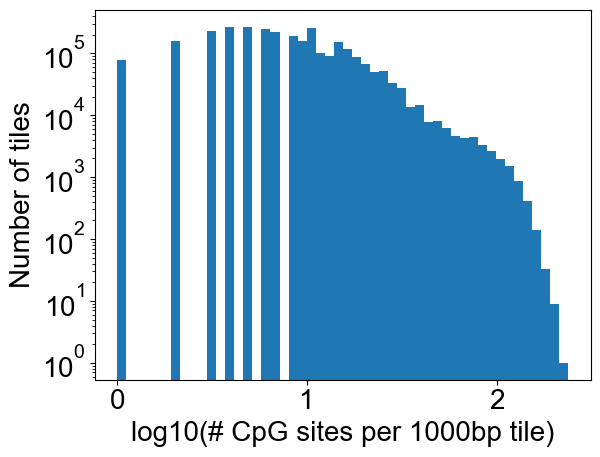

In [9]:
plt.hist(
    np.log10(DF_TILES_WITH_METH["num_cpgs"]), 
    bins=50, # type: ignore
    alpha=None, 
    label=None,
    color=None
)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel(f'log10(# CpG sites per {TILE_SIZE}bp tile)')
plt.ylabel('Number of tiles')

In [10]:
DF_TILES_WITH_METH.filter(pl.col('count_based_meth_pat').is_not_null())

chrom,start,end,num_cpgs,founder_pat,founder_mat,count_based_meth,model_based_meth,count_based_meth_pat,model_based_meth_pat,count_based_meth_mat,model_based_meth_mat
str,i64,i64,u32,list[str],list[str],f64,f64,f64,f64,f64,f64
"""chr1""",499000,500000,7,"[null, ""B""]","[""I"", null]",0.799667,0.933333,0.815,0.941667,0.851667,0.9385
"""chr1""",500000,501000,7,"[""B""]","[""I""]",0.748,0.890143,0.734857,0.908286,0.752143,0.855143
"""chr1""",501000,502000,6,"[""B"", null]","[null, ""I""]",0.734,0.887,0.806,0.95525,0.71025,0.83525
"""chr1""",502000,503000,9,"[""B""]","[""I""]",0.769111,0.904556,0.767,0.947667,0.762667,0.870556
"""chr1""",503000,504000,10,"[""B""]","[""I""]",0.8159,0.9336,0.8662,0.9469,0.799,0.9372
"""chr1""",504000,505000,6,"[""B""]","[""I""]",0.721167,0.839667,0.643667,0.758333,0.7795,0.931667
"""chr1""",505000,506000,9,"[""B""]","[""I""]",0.643333,0.721556,0.589111,0.625444,0.706333,0.79
"""chr1""",506000,507000,8,"[""B""]","[""I""]",0.77275,0.88875,0.781375,0.914125,0.77775,0.89025
"""chr1""",507000,508000,9,"[""B""]","[""I""]",0.83,0.946778,0.809111,0.951111,0.847889,0.949222


In [11]:
import methylation
importlib.reload(methylation)
from methylation import compute_delta_methylation

DF_TILES_WITH_DELTA_METH = compute_delta_methylation(DF_TILES_WITH_METH)
DF_TILES_WITH_DELTA_METH.filter(pl.col('delta_of_count_based_meth').is_not_null())

chrom,start,end,founder_pat,founder_mat,count_based_meth_pat,model_based_meth_pat,count_based_meth_mat,model_based_meth_mat,delta_of_count_based_meth,delta_of_model_based_meth
str,i64,i64,list[str],list[str],f64,f64,f64,f64,f64,f64
"""chr1""",499000,500000,"[null, ""B""]","[""I"", null]",0.815,0.941667,0.851667,0.9385,-0.036667,0.003167
"""chr1""",500000,501000,"[""B""]","[""I""]",0.734857,0.908286,0.752143,0.855143,-0.017286,0.053143
"""chr1""",501000,502000,"[""B"", null]","[null, ""I""]",0.806,0.95525,0.71025,0.83525,0.09575,0.12
"""chr1""",502000,503000,"[""B""]","[""I""]",0.767,0.947667,0.762667,0.870556,0.004333,0.077111
"""chr1""",503000,504000,"[""B""]","[""I""]",0.8662,0.9469,0.799,0.9372,0.0672,0.0097
"""chr1""",504000,505000,"[""B""]","[""I""]",0.643667,0.758333,0.7795,0.931667,-0.135833,-0.173333
"""chr1""",505000,506000,"[""B""]","[""I""]",0.589111,0.625444,0.706333,0.79,-0.117222,-0.164556
"""chr1""",506000,507000,"[""B""]","[""I""]",0.781375,0.914125,0.77775,0.89025,0.003625,0.023875
"""chr1""",507000,508000,"[""B""]","[""I""]",0.809111,0.951111,0.847889,0.949222,-0.038778,0.001889


## [All Samples] Compute difference of haplotype-specific methylations for all samples 

In [13]:
# The following cell takes 25 mins to run 

In [ ]:
# import imprinting 
# importlib.reload(imprinting)
# from imprinting import compute_delta_methylation_all_samples

# from write_data import write_dataframe_to_bed

# DF_DELTA_METH_ALL_SAMPLES = compute_delta_methylation_all_samples(REFERENCE_GENOME, TILE_SIZE, METH_READ_PHASED_DIR)
# write_dataframe_to_bed(DF_DELTA_METH_ALL_SAMPLES, 'delta_meth_all_samples.bed', source=globals()["__vsc_ipynb_file__"])

In [12]:
from read_data import read_dataframe_from_bed

def read_all_samples(bed): 
    df = read_dataframe_from_bed(bed)
    return (
        df
        .with_columns(
            pl.col(df.columns[3:]).cast(pl.Float64)
        )
    )

DF_DELTA_METH_ALL_SAMPLES = read_all_samples('delta_meth_all_samples.bed')
DF_DELTA_METH_ALL_SAMPLES.filter(pl.col('NA12877_count').is_not_null())

chrom,start,end,NA12877_count,NA12877_model,NA12878_count,NA12878_model,NA12887_count,NA12887_model,NA12885_count,NA12885_model,NA12883_count,NA12883_model,NA12881_count,NA12881_model,NA12879_count,NA12879_model,NA12886_count,NA12886_model,NA12884_count,NA12884_model,NA12882_count,NA12882_model,200081_count,200081_model,200082_count,200082_model,200084_count,200084_model,200085_count,200085_model,200086_count,200086_model,200087_count,200087_model,200101_count,200101_model,200102_count,200102_model,200103_count,200103_model,200104_count,200104_model,200105_count,200105_model,200106_count,200106_model
str,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""chr1""",689000,690000,-0.615,-0.6005,0.3785,0.4625,0.514,0.503,0.625,0.6795,-0.1895,-0.1605,0.529,0.489,-0.009,0.0955,-0.68,-0.781,0.316,0.3695,-0.741,-0.8125,-0.647,-0.6205,0.1695,0.216,0.575,0.6655,0.0975,0.146,-0.2235,-0.3575,null,null,0.7425,0.8255,0.7025,0.743,-0.6945,-0.6975,0.6615,0.599,-0.783,-0.8165,-0.463,-0.453
"""chr1""",690000,691000,0.15675,0.201875,-0.021857,-0.042857,-0.1825,-0.25475,-0.192375,-0.223375,-0.113,-0.156571,-0.20075,-0.21475,0.049875,0.057875,-0.05875,-0.062125,0.001,-0.021429,0.13525,0.185875,-0.027125,-0.0035,0.094375,0.099625,-0.163625,-0.188875,0.017375,-0.00325,-0.08525,-0.051875,null,null,-0.29475,-0.2855,-0.17075,-0.205375,0.339125,0.335,-0.254875,-0.246375,0.30875,0.344375,0.039143,0.054429
"""chr1""",691000,692000,0.009,-0.004333,0.119,0.020333,-0.037,-0.104333,0.03,-0.019667,-0.133667,-0.065667,0.011333,0.014333,-0.033,0.002667,-0.110333,-0.024333,0.003667,0.027667,0.118,0.06,-0.111667,-0.071333,0.148,0.031333,-0.048667,-0.012333,-0.027333,-0.009667,-0.062333,-0.013667,null,null,0.149333,0.143667,-0.015333,0.044333,0.027,0.059,-0.016667,-0.022333,-0.074333,-0.022,0.016,-0.000333
"""chr1""",692000,693000,0.1378,0.2147,-0.029667,-0.036667,-0.0797,-0.1447,-0.1364,-0.2169,0.024111,0.023778,-0.1932,-0.1845,0.001,-0.020667,0.0369,0.059,-0.039222,-0.113444,0.0572,0.1254,0.0299,0.0264,0.046111,0.058222,-0.197,-0.2446,-0.023333,-0.067778,-0.127444,-0.163444,-0.085861,-0.142778,-0.1103,-0.1048,-0.1216,-0.1566,0.0696,0.1291,-0.1999,-0.2653,0.0975,0.1075,0.058333,0.053667
"""chr1""",693000,694000,0.046562,0.084937,-0.026813,-0.077,-0.006875,-0.028875,-0.01,-0.03675,0.031563,0.033875,0.01475,0.031125,-0.018312,-0.024063,-0.041062,0.093,0.023125,0.016125,0.0275,0.057062,-0.097313,-0.062688,-0.050438,-0.0635,0.060625,0.046938,-0.04175,-0.044063,-0.029813,0.001875,-0.027313,-0.041125,-0.043438,-0.101813,-0.012688,-0.03375,0.048937,0.098375,0.01975,-0.007812,0.015437,0.05275,0.004,0.06475
"""chr1""",694000,695000,0.02675,0.03125,-0.02675,-0.0185,-0.0835,-0.0685,-0.0875,-0.08825,0.016375,0.059625,-0.042125,-0.08625,-0.0555,-0.047875,-0.042714,-0.054179,-0.00075,0.021125,-0.099875,-0.045125,0.005125,0.0025,-0.09,-0.1185,0.000875,-0.04975,0.065,0.048125,-0.046625,-0.052375,-0.02925,-0.030125,-0.010125,-0.011875,-0.036625,-0.025625,-0.009125,0.003,-0.046125,-0.0305,0.042875,0.02675,-0.041625,-0.02275
"""chr1""",695000,696000,0.0655,-0.006,-0.0975,-0.2915,0.185,0.083,0.019,-0.005,0.1265,0.177,-0.029,-0.0275,-0.1165,0.0785,-0.145,-0.0885,-0.078,-0.113,0.0105,0.0705,0.1475,0.1285,0.0445,-0.1325,0.1145,0.2395,-0.0085,-0.0325,-0.009,-0.065,-0.131,0.131,0.0095,0.106,0.056,-0.091,0.059,0.2135,-0.0435,-0.082,-0.007,0.0745,0.04,0.156
"""chr1""",696000,697000,-0.107,-0.1164,-0.0084,-0.0296,0.267,0.305,0.1602,0.1526,0.1806,0.1316,0.0824,0.0296,0.0928,0.0704,-0.2276,-0.28,0.0342,-0.009,-0.0844,-0.0978,-0.0128,0.0292,-0.0536,-0.0842,-0.0068,-0.0808,-0.0122,0.0258,0.0518,0.0436,-0.0946,-0.0584,0.052,0.062,0.1046,0.0956,-0.1318,-0.1342,0.1252,0.164,-0.1272,-0.1238,0.0478,-0.017
"""chr1""",697000,698000,0.004,0.017333,-0.028667,0.001333,0.018667,0.033667,-0.076,-0.051333,-0.087667,-0.164333,-0.066667,0.021,0.008333,0.111667,-0.157333,-0.2213

## [All Samples] Find candidate imprinted loci

In [13]:
def filter_to_imprinted_loci(df, delta_meth_threshold):
    delta_meth_cols = [col for col in df.columns if col not in ['chrom', 'start', 'end']]
    df = df.filter(pl.any_horizontal(pl.col(delta_meth_cols).abs() > delta_meth_threshold))
    # abs_value_exprs = [pl.col(col).abs() for col in delta_meth_cols]
    # df = df.with_columns(max_abs_value = pl.max_horizontal(abs_value_exprs))    
    return df

DF_IMPRINTED_CANDIDATES = filter_to_imprinted_loci(DF_DELTA_METH_ALL_SAMPLES, DELTA_METH_THRESHOLD)
DF_IMPRINTED_CANDIDATES

chrom,start,end,NA12877_count,NA12877_model,NA12878_count,NA12878_model,NA12887_count,NA12887_model,NA12885_count,NA12885_model,NA12883_count,NA12883_model,NA12881_count,NA12881_model,NA12879_count,NA12879_model,NA12886_count,NA12886_model,NA12884_count,NA12884_model,NA12882_count,NA12882_model,200081_count,200081_model,200082_count,200082_model,200084_count,200084_model,200085_count,200085_model,200086_count,200086_model,200087_count,200087_model,200101_count,200101_model,200102_count,200102_model,200103_count,200103_model,200104_count,200104_model,200105_count,200105_model,200106_count,200106_model
str,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""chr1""",3973000,3974000,-0.048952,-0.046,null,null,0.003571,0.006095,-0.034429,-0.055905,-0.040429,-0.043286,null,null,0.07781,0.082762,-0.066571,-0.065571,-0.034857,-0.054238,null,null,-0.010333,-0.00381,0.152857,0.111429,0.013143,-0.006333,0.043952,0.037667,0.046095,-0.019619,0.089524,0.114,-0.042476,-0.065143,-0.771333,-0.775571,-0.019467,-0.047339,-0.072619,-0.065143,-0.941,-0.899,null,null
"""chr1""",5248000,5249000,0.967,0.852,null,null,null,null,0.944,0.858,0.842,0.866,null,null,null,null,null,null,0.789,0.852,null,null,null,null,0.75,0.884,-0.8,-0.782,0.769,0.799,-0.036,0.147,null,null,null,null,0.708,0.791,null,null,null,null,0.846,0.82,0.882,0.863
"""chr1""",5339000,5340000,-0.1305,-0.1399,0.033,0.004333,0.1641,0.1905,0.084111,0.017444,0.075444,-0.005778,0.1617,0.2037,-0.033556,-0.078667,-0.026778,-0.024222,-0.031222,-0.079778,0.1005,0.1688,0.1572,0.1459,-0.9,-0.913,0.1999,0.1571,-0.005222,-0.033444,-0.090778,-0.082333,null,null,-0.1695,-0.213,-0.003444,-0.003222,-0.0498,-0.0624,-0.0923,-0.1104,-0.1404,-0.1552,0.012778,0.021778
"""chr1""",12222000,12223000,null,null,-0.86,-0.896,null,null,null,null,null,null,-0.733,-0.878,null,null,null,null,null,null,0.727,0.861,-0.769,-0.901,-0.625,-0.762,null,null,-0.9,-0.892,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""chr1""",12304000,12305000,0.0603,0.0817,null,null,0.032556,0.028778,0.0714,0.0975,0.1669,0.1593,0.0284,0.0836,0.103,0.1026,0.126,0.0833,0.1074,0.1038,0.0635,0.0782,0.1355,0.1325,-0.039444,-0.000556,null,null,0.040333,0.031222,null,null,-0.789,-0.906,-0.011889,0.005333,0.1007,0.0939,-0.030333,-0.007222,-0.0145,0.0568,0.0934,0.0761,0.142,0.1037
"""chr1""",12442000,12443000,0.048714,0.018,0.069857,-0.017,-0.100143,0.007571,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.053857,0.009571,0.909,0.891,null,null,0.9,0.908,0.647,0.78,0.8,0.886,0.037143,-0.026143,-0.070286,-0.013714,null,null,0.024143,-0.010143,-0.012,-0.037286,null,null
"""chr1""",15255000,15256000,null,null,0.603,0.667,-0.6122,-0.688,-0.6618,-0.7238,-0.5846,-0.6258,0.067,0.006,null,null,null,null,-0.664,-0.7424,null,null,0.5732,0.66,0.055,0.014,0.5822,0.675,null,null,0.5686,0.6504,null,null,0.0042,-0.0246,0.0016,-0.0496,null,null,-0.002,-0.003,0.007,-0.027,-0.9054,-0.912
"""chr1""",16286000,16287000,-0.031125,-0.010625,null,null,-0.063125,0.01675,0.050125,0.04625,-0.006,-0.039625,null,null,null,null,-0.05675,-0.0585,0.046375,0.00525,0.142875,0.0595,-0.1355,-0.156375,-0.176625,-0.167375,-0.095125,-0.1195,-0.04375,-0.109875,null,null,-0.060375,-0.092625,1.0,0.905,0.085875,0.0805,null,null,-0.01775,0.005125,0.02725,0.0145,0.107375,0.056875
"""chr1""",20650000,20651000,-0.094769,-0.122308,null,null,0.056385,0.008923,-0.037077,-0.074769,-0.034154,-0.028846,-0.064385,-0.111385,null,null,-0.064077,-0.051769,-0.081846,-0.064462,-0.061538,-0.065154,-0.080923,-0.012462,null,null,0.077923,0.059846,-0.032154,0.006077,0.100769,0.129769,0.043308,0.03,-0.032846,0.013615,0.071,0.019,-0.001923,-0.014462,-0.187571,-0.178143,-0.077,-0.098929,-0.846,-0.901


## [All samples] Compare candidate imprinted loci with a truth set

In [ ]:
def read_truth_set_imprinted_loci(): 
    df = (
        pl
        # https://quinlangroup.slack.com/archives/C0803TM7X0X/p1758742312373849
        # https://www.tandfonline.com/doi/10.1080/15592294.2022.2091815
        .read_csv(
            't0001-10.1080_15592294.2022.2091815.csv', 
            separator=',',
            comment_prefix=None,
            has_header=True,
        )
        .with_columns(
            pl.col("Genomic Coordinates").str.split_exact(":", 1)  # Split by ":" into two parts
            .struct.rename_fields(["chrom", "start-end"])          
            .alias("split_colon")
        )
        .unnest("split_colon")
        .with_columns(
            pl.col("start-end").str.split_exact("-", 1) # Split by "-" into two parts
            .struct.rename_fields(["start", "end"])     
            .alias("split_dash")
        )
        .unnest("split_dash")
        .drop(["start-end", "Genomic Coordinates"])
        .with_columns(
            pl.col("Distance to Nearest Transcript")
            .str.replace_all(",", "")  # Step 1: Remove all commas
            .cast(pl.Int64)            # Step 2: Cast the cleaned string to i64
        )
        .cast({
            "start": pl.Int64,
            "end": pl.Int64,
        })
        .with_columns(
            (pl.col('end') - pl.col('start')).alias('length')
        )
    )

    return df.select(['chrom', 'start', 'end', 'length'] + df.columns[:-4])

DF_IMPRINTED_TRUTH = read_truth_set_imprinted_loci()
DF_IMPRINTED_TRUTH
# ICRs overlapping ENCODE annotated regions of CTCF binding and DNase I hypersensitivity are indicated by * and ^, respectively. 
# ICRs overlapping previously published ICRs of imprinted genes are indicated by #.

chrom,start,end,length,ID,Parental Origin of Methylation,Nearest Transcript,Distance to Nearest Transcript
str,i64,i64,i64,str,str,str,i64
"""chr1""",628959,630792,1833,"""ICR_2^""","""P""","""MTND1P23|MTND2P28""",0
"""chr1""",632183,632834,651,"""ICR_3^""","""P""","""MTCO1P12|MIR12136|MTCO2P12""",0
"""chr1""",633381,634921,1540,"""ICR_4^""","""P""","""MTCO2P12|MTATP8P1|MTATP6P1|MTC…",0
"""chr1""",1174554,1174597,43,"""ICR_6*""","""P""","""TTLL10""",0
"""chr1""",2469095,2469433,338,"""ICR_10^""","""P""","""PLCH2""",0
"""chr1""",2661644,2661722,78,"""ICR_12""","""M""","""TTC34""",0
"""chr1""",6461637,6461737,100,"""ICR_15""","""M""","""TNFRSF25""",0
"""chr1""",7199286,7199687,401,"""ICR_16^""","""M""","""CAMTA1""",0
"""chr1""",8117511,8117827,316,"""ICR_17^""","""P""","""RPL7AP18""",59024


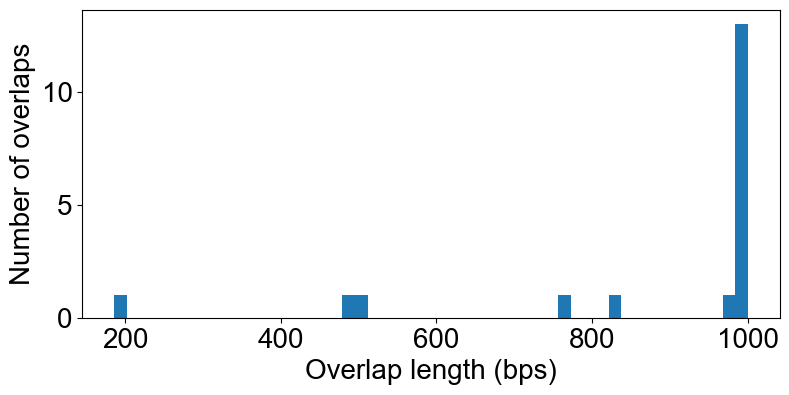

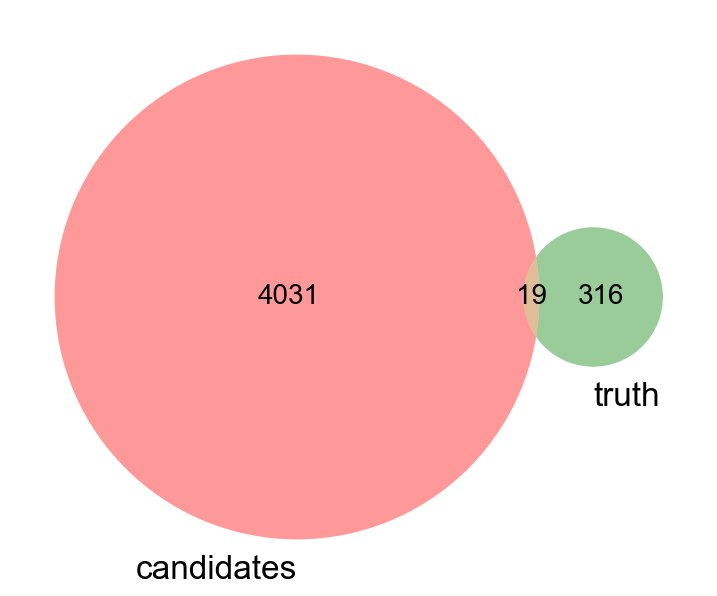

In [16]:
def compute_overlaps(df1, df2, suffixes, set_labels):
    df = bf.overlap(
        df1.to_pandas(),
        df2.to_pandas(),
        how='inner',
        suffixes=suffixes,
        return_overlap=True
    )
    df = version_sort(
        pl
        .from_pandas(df)
        .with_columns(
            (pl.col('overlap_end') - pl.col('overlap_start')).alias('overlap')
        )
    )

    plt.figure(figsize=(9, 4))
    plt.hist(
        df["overlap"], 
        bins=50, # type: ignore
        alpha=None, 
        label=None,
        color=None
    )
    plt.xscale('linear')
    plt.yscale('linear')
    plt.xlabel(f'Overlap length (bps)')
    plt.ylabel('Number of overlaps')    
    plt.show() 

    count_1 = len(df1)
    count_2 = len(df2)
    count_overlap = len(df)
    plt.figure(figsize=(9, 9))
    venn2(
        subsets=(count_1 - count_overlap, count_2 - count_overlap, count_overlap),
        set_labels=set_labels
    )
    plt.show()
                    
    return df

DF_IMPRINTED_COMMON = compute_overlaps(DF_IMPRINTED_CANDIDATES, DF_IMPRINTED_TRUTH, suffixes=('', '_truth'), set_labels=('candidates', 'truth'))

In [ ]:
# Almost all candidate loci that are found in the truth set are predicted to be methylated on maternal haplotype  
# "Previously reported ICRs that do not have gamete specific methylation are also included and labelled as having Somatic (S) methylation. "
Counter(DF_IMPRINTED_COMMON['Parental Origin of Methylation_truth'].to_numpy())

Counter({'M': 18, 'S': 1})

## [All Samples] Inspect consistency of methylation on pat and mat haplotypes at candidate imprinted loci across samples 

In [ ]:
# This cell takes 5mins to run:

In [ ]:
# import imprinting 
# importlib.reload(imprinting)
# from imprinting import compute_methylation_all_samples_at_given_loci

# from write_data import write_dataframe_to_bed

# DF_METH_IMPRINTED_ALL_SAMPLES = compute_methylation_all_samples_at_given_loci(DF_IMPRINTED_CANDIDATES, METH_READ_PHASED_DIR)
# write_dataframe_to_bed(DF_METH_IMPRINTED_ALL_SAMPLES, 'imprinted_meth_all_samples.bed', source=globals()["__vsc_ipynb_file__"])

 42%|████▏     | 10/24 [02:21<03:11, 13.68s/it]

Could not read CpG sites at which count- and model-based methylation levels have been phased to founder haplotypes
Required file does not exist: '/scratch/ucgd/lustre-labs/quinlan/data-shared/dna-methylation/CEPH1463.GRCh38.hifi.founder-phased.all-cpgs/200080.dna-methylation.founder-phased.all_cpgs.bed'
This may be because this sample is a founder and therefore cannot be inheritance-based phased


 71%|███████   | 17/24 [03:39<01:26, 12.39s/it]

Could not read CpG sites at which count- and model-based methylation levels have been phased to founder haplotypes
Required file does not exist: '/scratch/ucgd/lustre-labs/quinlan/data-shared/dna-methylation/CEPH1463.GRCh38.hifi.founder-phased.all-cpgs/200100.dna-methylation.founder-phased.all_cpgs.bed'
This may be because this sample is a founder and therefore cannot be inheritance-based phased


100%|██████████| 24/24 [05:06<00:00, 12.77s/it]


In [35]:
DF_METH_IMPRINTED_CANDIDATES = read_all_samples('imprinted_meth_all_samples.bed')
DF_METH_IMPRINTED_CANDIDATES

chrom,start,end,NA12877_count_based_meth_pat,NA12877_model_based_meth_pat,NA12877_count_based_meth_mat,NA12877_model_based_meth_mat,NA12878_count_based_meth_pat,NA12878_model_based_meth_pat,NA12878_count_based_meth_mat,NA12878_model_based_meth_mat,NA12887_count_based_meth_pat,NA12887_model_based_meth_pat,NA12887_count_based_meth_mat,NA12887_model_based_meth_mat,NA12885_count_based_meth_pat,NA12885_model_based_meth_pat,NA12885_count_based_meth_mat,NA12885_model_based_meth_mat,NA12883_count_based_meth_pat,NA12883_model_based_meth_pat,NA12883_count_based_meth_mat,NA12883_model_based_meth_mat,NA12881_count_based_meth_pat,NA12881_model_based_meth_pat,NA12881_count_based_meth_mat,NA12881_model_based_meth_mat,NA12879_count_based_meth_pat,NA12879_model_based_meth_pat,NA12879_count_based_meth_mat,NA12879_model_based_meth_mat,NA12886_count_based_meth_pat,NA12886_model_based_meth_pat,NA12886_count_based_meth_mat,NA12886_model_based_meth_mat,NA12884_count_based_meth_pat,NA12884_model_based_meth_pat,…,200084_model_based_meth_mat,200085_count_based_meth_pat,200085_model_based_meth_pat,200085_count_based_meth_mat,200085_model_based_meth_mat,200086_count_based_meth_pat,200086_model_based_meth_pat,200086_count_based_meth_mat,200086_model_based_meth_mat,200087_count_based_meth_pat,200087_model_based_meth_pat,200087_count_based_meth_mat,200087_model_based_meth_mat,200101_count_based_meth_pat,200101_model_based_meth_pat,200101_count_based_meth_mat,200101_model_based_meth_mat,200102_count_based_meth_pat,200102_model_based_meth_pat,200102_count_based_meth_mat,200102_model_based_meth_mat,200103_count_based_meth_pat,200103_model_based_meth_pat,200103_count_based_meth_mat,200103_model_based_meth_mat,200104_count_based_meth_pat,200104_model_based_meth_pat,200104_count_based_meth_mat,200104_model_based_meth_mat,200105_count_based_meth_pat,200105_model_based_meth_pat,200105_count_based_meth_mat,200105_model_based_meth_mat,200106_count_based_meth_pat,200106_model_based_meth_pat,200106_count_based_meth_mat,200106_model_based_meth_mat
str,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""chr1""",3973000,3974000,0.740476,0.789286,0.789429,0.835286,null,null,null,null,0.865476,0.926048,0.861905,0.919952,0.75681,0.790524,0.791238,0.846429,0.776857,0.832905,0.817286,0.87619,null,null,null,null,0.801619,0.848381,0.72381,0.765619,0.775333,0.832238,0.841905,0.89781,0.807524,0.849571,…,0.866048,0.841143,0.905762,0.79719,0.868095,0.806238,0.852571,0.760143,0.87219,0.814905,0.889048,0.725381,0.775048,0.769238,0.816333,0.811714,0.881476,0.0,0.055,0.771333,0.830571,0.789095,0.850286,0.8085625,0.897625,0.75219,0.821714,0.82481,0.886857,0.0,0.049,0.941,0.948,0.850286,0.903095,null,null
"""chr1""",5248000,5249000,0.967,0.93,0.0,0.078,null,null,null,null,null,null,null,null,0.944,0.929,0.0,0.071,0.842,0.931,0.0,0.065,null,null,null,null,null,null,0.0,0.073,null,null,null,null,0.789,0.924,…,0.869,0.769,0.871,0.0,0.072,0.75,0.926,0.786,0.779,0.895,0.929,null,null,null,null,null,null,0.708,0.864,0.0,0.073,null,null,null,null,null,null,0.0,0.084,0.846,0.881,0.0,0.061,0.882,0.945,0.0,0.082
"""chr1""",5339000,5340000,0.6241,0.7264,0.7546,0.8663,0.725333,0.781667,0.692333,0.777333,0.8016,0.8943,0.6375,0.7038,0.744778,0.788778,0.660667,0.771333,0.794222,0.887556,0.718778,0.893333,0.7331,0.8601,0.5714,0.6564,0.656667,0.759333,0.690222,0.838,0.690444,0.853889,0.717222,0.878111,0.674667,0.76,…,0.6862,0.647778,0.707333,0.653,0.740778,0.583667,0.680222,0.674444,0.762556,0.687667,0.799889,null,null,0.5734,0.655,0.7429,0.868,0.694222,0.766111,0.697667,0.769333,0.6136,0.7025,0.6634,0.7649,0.6537,0.7105,0.746,0.8209,0.6379,0.7285,0.7783,0.8837,0.734556,0.859,0.721778,0.837222
"""chr1""",12222000,12223000,null,null,null,null,0.0,0.059,0.86,0.955,nu

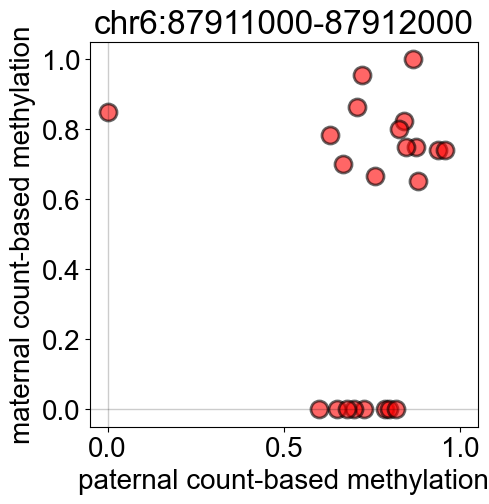

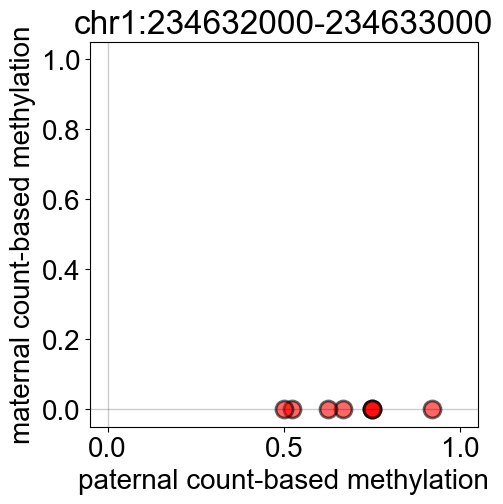

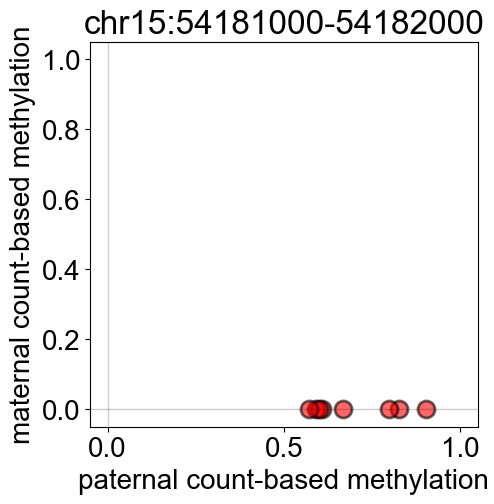

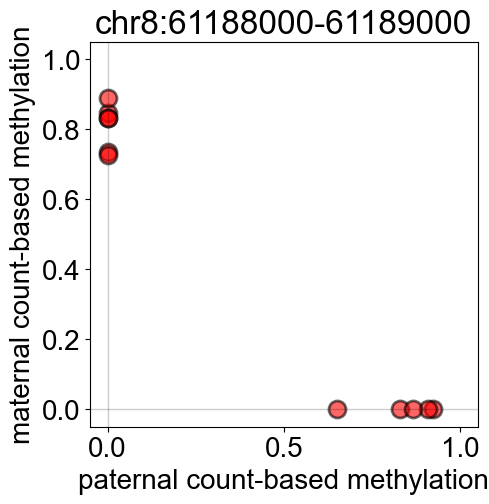

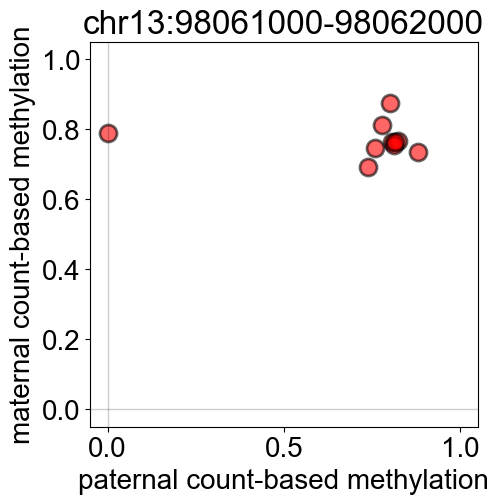

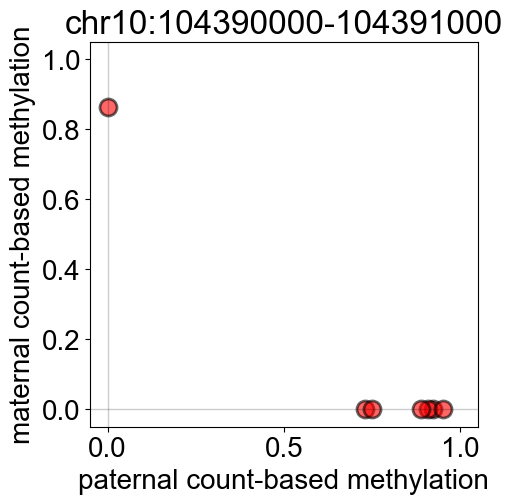

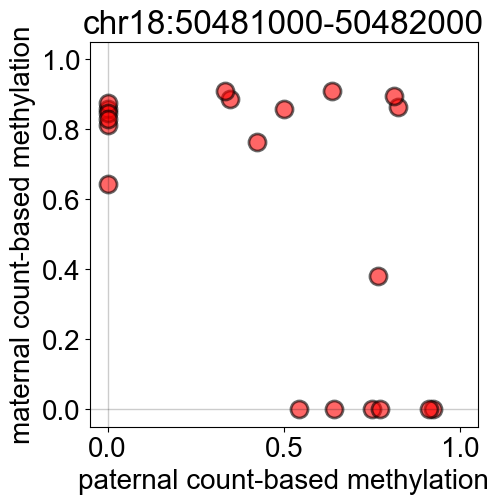

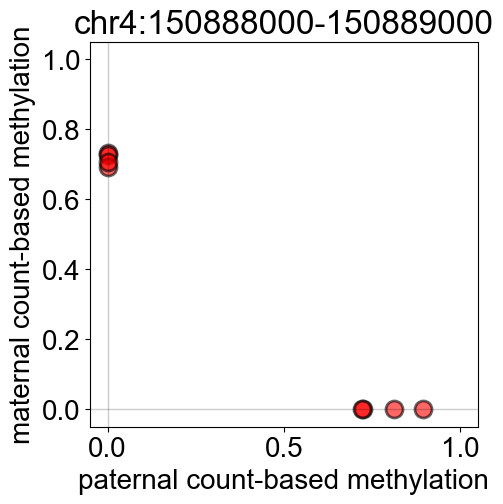

In [34]:
from get_palladium_prefixes import get_prefixes_wrapper

def plot_mat_vs_pat_meth(df, mode): 
    df = df.sample(8)
    for locus in df.iter_rows(named=True):
        chrom, start, end = locus['chrom'], locus['start'], locus['end']
        coordinate = f"{chrom}:{start}-{end}"
        meths_pat, meths_mat = [], []
        for prefix in get_prefixes_wrapper():
            try:
                meths_pat.append(locus[f'{prefix}_{mode}_based_meth_pat'])
                meths_mat.append(locus[f'{prefix}_{mode}_based_meth_mat'])
            except KeyError: 
                continue
        # for meth_pat, meth_mat in zip(meths_pat, meths_mat): 
        #     print(meth_pat, meth_mat)
        plt.figure(figsize=(5,5))
        plt.scatter(
            meths_pat, 
            meths_mat,
            s=150,          
            marker='o',     
            edgecolor='black', 
            linewidths=2,   
            facecolor='red', 
            alpha=0.6   
        )
        plt.title(coordinate)
        plt.xlim(-0.05, 1.05)
        plt.ylim(-0.05, 1.05)
        plt.axvline(x=0, color='k', linestyle='-', linewidth=1, alpha=0.2)
        plt.axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.2)
        plt.xlabel(f'paternal {mode}-based methylation')
        plt.ylabel(f'maternal {mode}-based methylation')
        plt.show()
        
plot_mat_vs_pat_meth(DF_METH_IMPRINTED_CANDIDATES, mode='count')

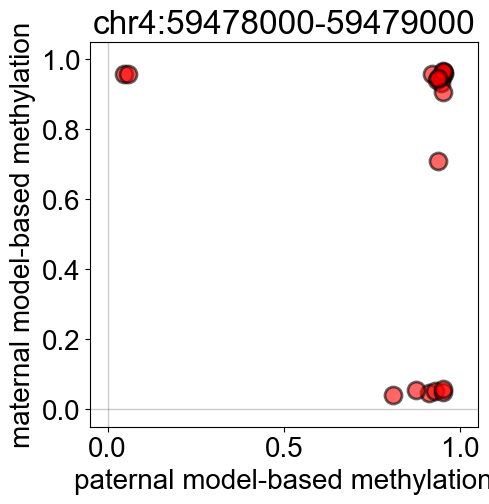

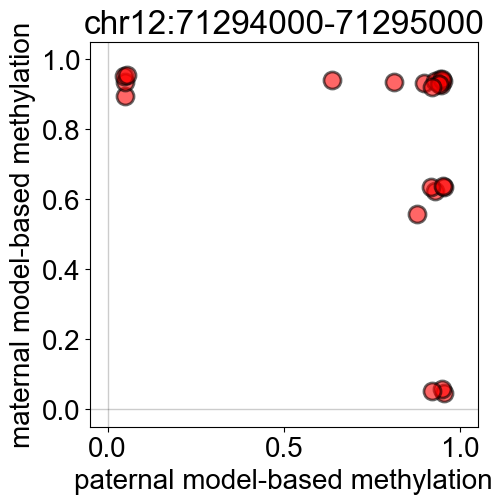

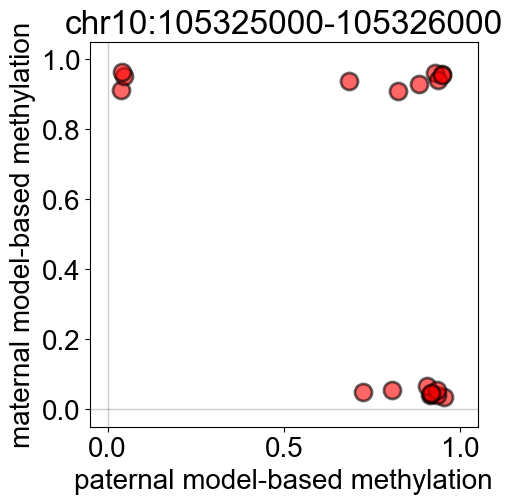

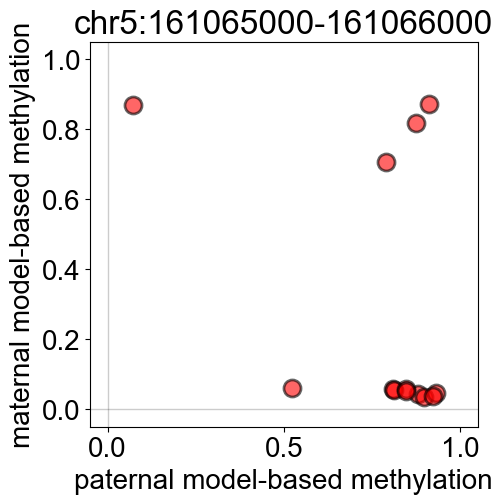

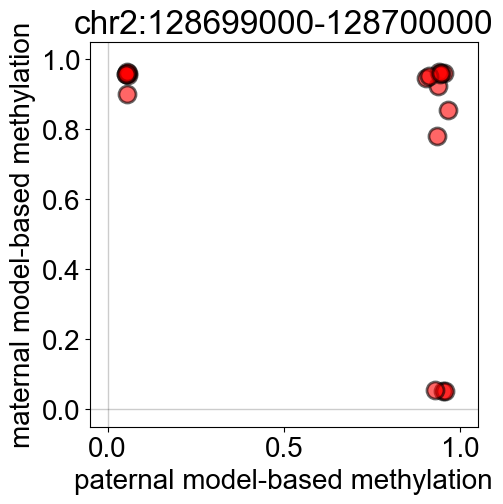

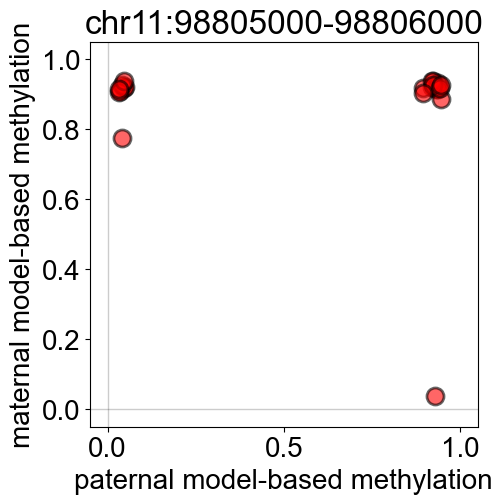

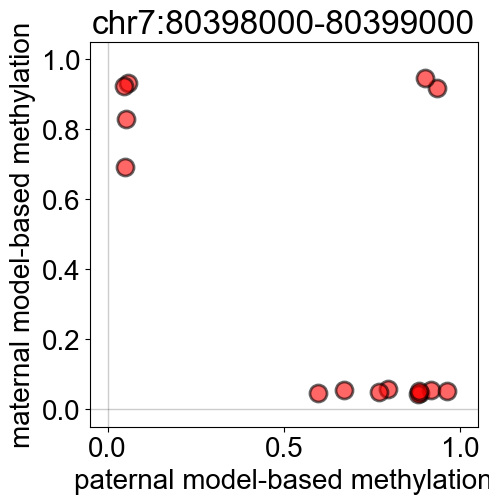

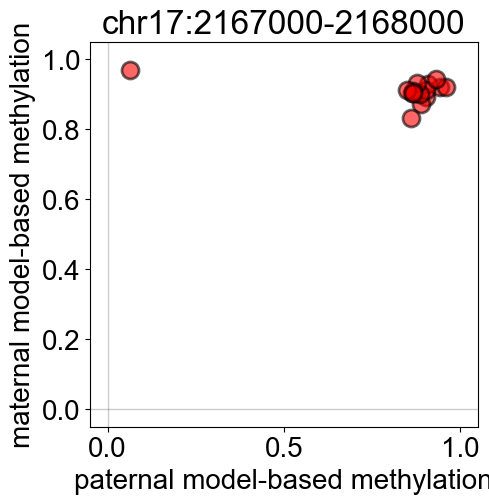

In [36]:
plot_mat_vs_pat_meth(DF_METH_IMPRINTED_CANDIDATES, mode='model')

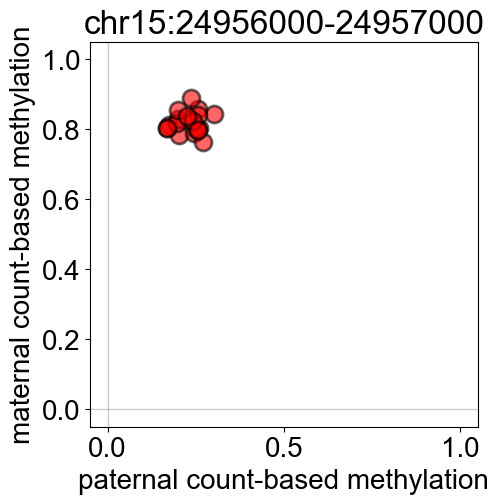

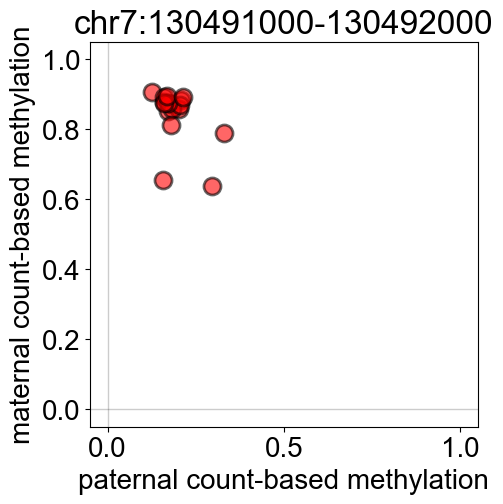

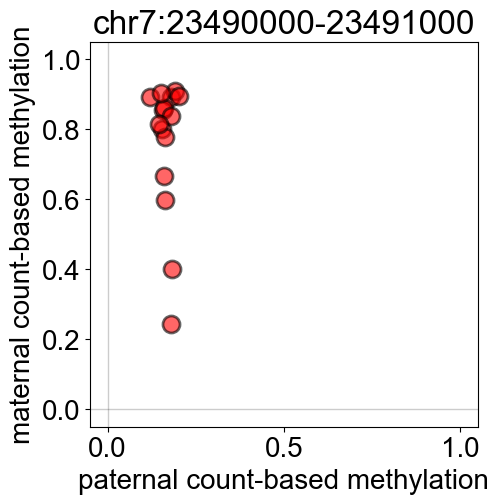

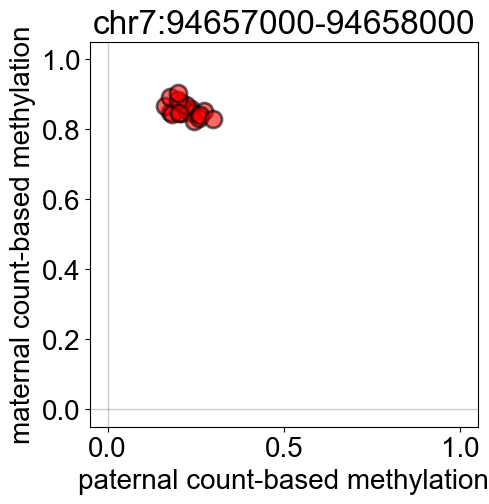

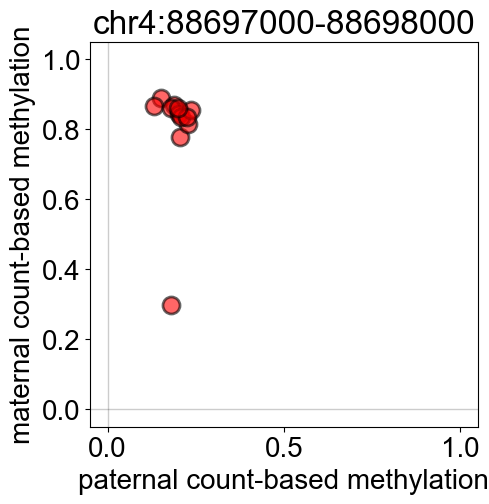

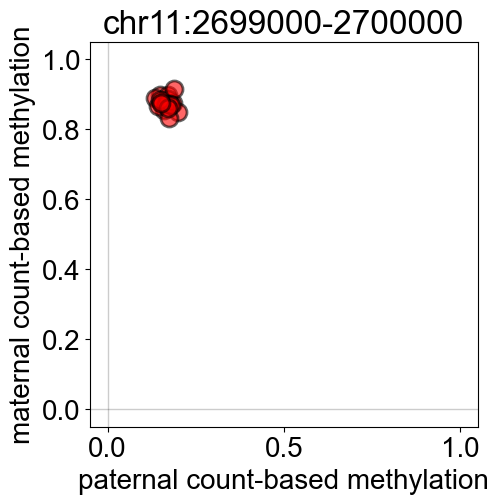

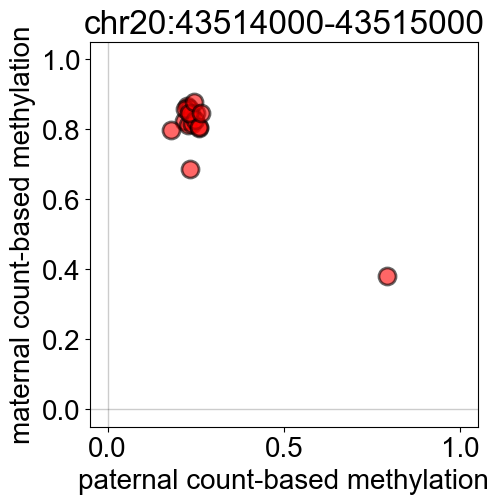

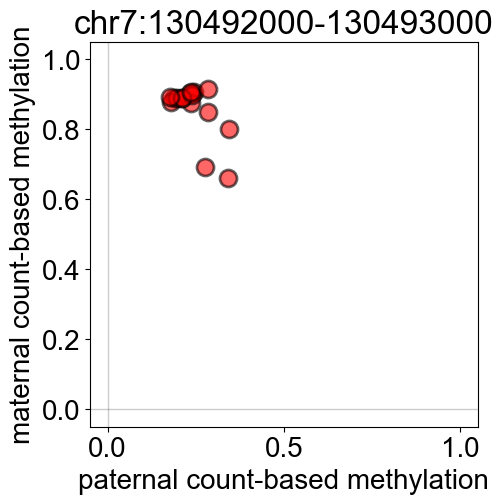

In [39]:
plot_mat_vs_pat_meth(
    DF_METH_IMPRINTED_CANDIDATES.join(DF_IMPRINTED_COMMON.select(['chrom', 'start', 'end']), on=['chrom', 'start', 'end'], how='inner'), 
    mode='count'
)

In [ ]:
# TODO 
# inspect candidate imprinted loci where meth_{allele}_count is 0.0 by generalizing compute_methylation_all_samples_at_given_loci to pull through more data, e.g, num_cpgs, etc 

In [ ]:
# TODO 
# identify polymorphic loci and their overlap with polymorphic truth set 
# correlate delta_meth or (meth_pat, meth_mat), with position in pedigree by plotting on pedigree graph 
# for polymorphic loci, does meth_pat, meth_mat, delta_meth covary with founder haplotype or degree of relationship? 

In [ ]:
# TODO: 
# can compute_methylation_all_samples_at_given_loci be combined with compute_delta_methylation_all_samples via refactoring? 
# label imprinted_meth_all_samples.bed with value of DELTA_METH_THRESHOLD